Install Dependencies

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.2 MB/s eta 0:00:00


Import necessary libraries and set up paths

In [ ]:
# Import necessary libraries
import os  # Provides a way of using operating system-dependent functionality like reading or writing to the file system.
import numpy as np  # Fundamental package for scientific computing with Python, used for handling arrays and matrices, and performing mathematical operations.
import tensorflow as tf  # An open-source platform for machine learning and artificial intelligence, used for building and deploying machine learning models.
import tensorflow.keras as keras  # Keras is a high-level neural networks API, running on top of TensorFlow, used for building and training deep learning models.
from keras.preprocessing.image import ImageDataGenerator  # A class for generating batches of tensor image data with real-time data augmentation.
from keras.applications import EfficientNetB0  # EfficientNetB0 is a pre-trained convolutional neural network model, used for transfer learning and fine-tuning.
from keras.layers import GlobalAveragePooling2D, Dense, Dropout  # Importing specific layers: GlobalAveragePooling2D for down-sampling, Dense for fully connected layers, and Dropout for regularisation.
from keras.models import Model  # The Model class is used to create a model by grouping layers into an object.
from keras.optimizers import Adam  # Adam optimiser, used to minimise the loss function during training.
from keras.callbacks import Callback  # Callback class, used to define custom behaviour at different stages of training.
from sklearn.model_selection import train_test_split  # Utility function for splitting the dataset into training and testing sets.
from keras_tuner.tuners import RandomSearch  # RandomSearch tuner from Keras Tuner, used for hyperparameter tuning.
import matplotlib.pyplot as plt  # A plotting library for creating static, interactive, and animated visualisations in Python.

Set up data generators

In [ ]:
# Define data paths
train_dir = '/content/drive/MyDrive/Colab Notebooks/data/Training'  # Path to the training data directory.
test_dir = '/content/drive/MyDrive/Colab Notebooks/data/Testing'  # Path to the testing data directory.

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1].
    shear_range=0.2,  # Apply random shear transformations.
    zoom_range=0.2,  # Apply random zoom transformations.
    horizontal_flip=True,  # Randomly flip images horizontally.
    rotation_range=30,  # Randomly rotate images by up to 30 degrees.
    width_shift_range=0.3,  # Randomly shift images horizontally by up to 30% of the width.
    height_shift_range=0.3,  # Randomly shift images vertically by up to 30% of the height.
    brightness_range=[0.8, 1.2],  # Randomly change the brightness of images.
    fill_mode='nearest',  # Fill in new pixels with the nearest pixel value after transformations.
    validation_split=0.2  # Split 20% of the data for validation.
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale the pixel values from [0, 255] to [0, 1] for test data.

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directory of the training data.
    target_size=(128, 128),  # Resize all images to 128x128 pixels.
    batch_size=32,  # Number of images to yield per batch.
    class_mode='categorical',  # Return one-hot encoded labels.
    subset='training'  # Use the 'training' subset of the data.
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,  # Directory of the training data.
    target_size=(128, 128),  # Resize all images to 128x128 pixels.
    batch_size=32,  # Number of images to yield per batch.
    class_mode='categorical',  # Return one-hot encoded labels.
    subset='validation'  # Use the 'validation' subset of the data.
)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Directory of the testing data.
    target_size=(128, 128),  # Resize all images to 128x128 pixels.
    batch_size=32,  # Number of images to yield per batch.
    class_mode='categorical'  # Return one-hot encoded labels.
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Define the model

In [ ]:
def create_model(learning_rate=0.001, dropout_rate=0.5):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))  # Load the EfficientNetB0 model with pre-trained ImageNet weights, excluding the top classification layer, and specifying the input shape.
    x = base_model.output  # Get the output of the base model.
    x = GlobalAveragePooling2D()(x)  # Apply global average pooling to reduce the spatial dimensions.
    x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units and ReLU activation.
    x = Dropout(dropout_rate)(x)  # Apply dropout regularisation with the specified dropout rate.
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Add a final dense layer with a softmax activation for classification, where the number of units equals the number of classes.
    model = Model(inputs=base_model.input, outputs=predictions)  # Create the model with the base model inputs and the new output layer.

    for layer in base_model.layers:
        layer.trainable = False  # Freeze all layers of the base model to prevent them from being trained.

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the model with the Adam optimiser, categorical cross-entropy loss, and accuracy as a metric.
    return model  # Return the compiled model.

Set up reinforcement learning elements

In [ ]:
class CustomCallback(Callback):
    def __init__(self, model, env):
        self.model = model  # Initialise the model attribute with the provided model.
        self.env = env  # Initialise the environment attribute with the provided environment.

    def on_epoch_end(self, epoch, logs=None):
        reward = self.env.step()  # Perform a step in the custom environment and get the reward.
        # Incorporate reward into training process
        print(f'Epoch {epoch+1}: Reward {reward}')  # Print the reward obtained at the end of the epoch.

Hyperparameter tuning using Keras Tuner

In [ ]:
def build_model(hp):
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])  # Hyperparameter for learning rate, choosing from 0.01, 0.001, or 0.0001.
    dropout_rate = hp.Choice('dropout_rate', [0.3, 0.4, 0.5])  # Hyperparameter for dropout rate, choosing from 0.3, 0.4, or 0.5.
    return create_model(learning_rate, dropout_rate)  # Create and return the model with the chosen hyperparameters.

tuner = RandomSearch(
    build_model,  # The model-building function to optimise.
    objective='val_accuracy',  # Objective to maximise during hyperparameter tuning (validation accuracy).
    max_trials=5,  # Maximum number of different hyperparameter combinations to try.
    executions_per_trial=3,  # Number of times to train the model for each hyperparameter combination.
    directory='my_dir',  # Directory to save the tuning results.
    project_name='brain_tumour_classification'  # Name of the tuning project.
)

tuner.search_space_summary()  # Print a summary of the search space.

# Perform the search
tuner.search(train_generator, epochs=1, validation_data=validation_generator)  # Start the hyperparameter search, training each model for 1 epoch.

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]  # Retrieve the best hyperparameters from the search.
print(f'Best hyperparameters: {best_hps.values}')  # Print the values of the best hyperparameters.

Trial 5 Complete [00h 10m 16s]
val_accuracy: 0.26321940620740253

Best val_accuracy So Far: 0.2713993589083354
Total elapsed time: 01h 06m 45s
Best hyperparameters: {'learning_rate': 0.01, 'dropout_rate': 0.3}


Train the model with reinforcement learning elements

In [ ]:
# Build the model with the optimal hyperparameters
model = build_model(best_hps)  # Build the model using the best hyperparameters obtained from the tuning process.

# Custom environment for reinforcement learning
class CustomEnv:
    def step(self):
        # Define custom reward mechanism
        return np.random.rand()  # Example reward, returning a random value as the reward.

env = CustomEnv()  # Instantiate the custom environment.

# Train the model with custom callback
history = model.fit(
    train_generator,  # The training data generator.
    epochs=5,  # Number of epochs to train the model.
    validation_data=validation_generator,  # The validation data generator.
    callbacks=[CustomCallback(model, env)]  # List of callbacks to be called during training, including the custom callback.
)

Epoch 1/5
143/143 [==============================] - 196s 1s/step - loss: 1.7735 - accuracy: 0.2665 - val_loss: 1.3837 - val_accuracy: 0.2796
Epoch 2/5
143/143 [==============================] - 187s 1s/step - loss: 1.3867 - accuracy: 0.2767 - val_loss: 1.3834 - val_accuracy: 0.2796
Epoch 3/5
143/143 [==============================] - 182s 1s/step - loss: 1.3844 - accuracy: 0.2787 - val_loss: 1.3838 - val_accuracy: 0.2796
Epoch 4/5
143/143 [==============================] - 183s 1s/step - loss: 1.3843 - accuracy: 0.2730 - val_loss: 1.3838 - val_accuracy: 0.2796
Epoch 5/5
143/143 [==============================] - 181s 1s/step - loss: 1.3847 - accuracy: 0.2792 - val_loss: 1.3834 - val_accuracy: 0.2796


Evaluate the model

In [ ]:
# Evaluate the model on the test data
results = model.evaluate(test_generator)  # Evaluate the model's performance on the test data using the test data generator.

# Print the test loss and accuracy
print(f'Test loss: {results[0]}')  # Print the loss value obtained from the evaluation.
print(f'Test accuracy: {results[1]}')  # Print the accuracy value obtained from the evaluation.

41/41 [==============================] - 341s 8s/step - loss: 1.3798 - accuracy: 0.3089
Test loss: 1.3798054456710815
Test accuracy: 0.30892449617385864


Plot the training history

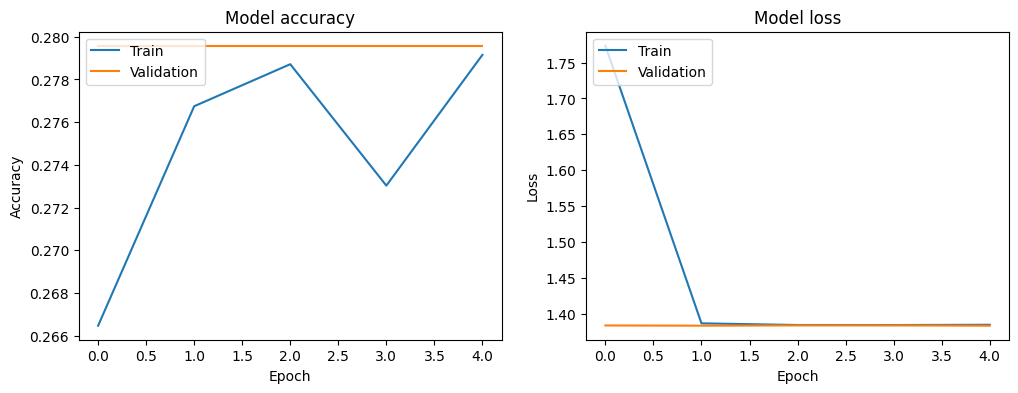

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))  # Create a figure with a specified size.
plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, first subplot).
plt.plot(history.history['accuracy'])  # Plot the training accuracy values.
plt.plot(history.history['val_accuracy'])  # Plot the validation accuracy values.
plt.title('Model accuracy')  # Set the title of the accuracy plot.
plt.ylabel('Accuracy')  # Set the y-axis label for accuracy.
plt.xlabel('Epoch')  # Set the x-axis label as epoch.
plt.legend(['Train', 'Validation'], loc='upper left')  # Add a legend indicating training and validation curves.

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, second subplot).
plt.plot(history.history['loss'])  # Plot the training loss values.
plt.plot(history.history['val_loss'])  # Plot the validation loss values.
plt.title('Model loss')  # Set the title of the loss plot.
plt.ylabel('Loss')  # Set the y-axis label for loss.
plt.xlabel('Epoch')  # Set the x-axis label as epoch.
plt.legend(['Train', 'Validation'], loc='upper left')  # Add a legend indicating training and validation curves.

plt.show()  # Display the plots.

Displaying the confusion matrix and classification report

41/41 [==============================] - 57s 1s/step


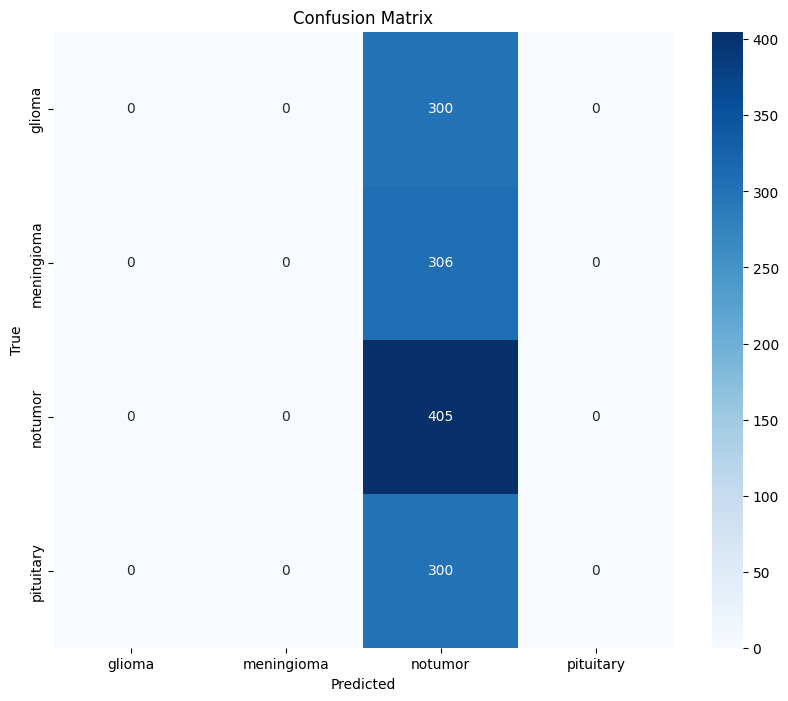

Classification Report
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.31      1.00      0.47       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.31      1311
   macro avg       0.08      0.25      0.12      1311
weighted avg       0.10      0.31      0.15      1311



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report  # Import functions for generating a confusion matrix and classification report.
import seaborn as sns  # Import seaborn for data visualisation.
import matplotlib.pyplot as plt  # Import matplotlib for plotting.

# Predict the labels for the test data
Y_pred = model.predict(test_generator)  # Predict the probabilities for the test data using the model.
y_pred = np.argmax(Y_pred, axis=1)  # Get the predicted class labels by taking the argmax of the predictions.

# Get the true labels
y_true = test_generator.classes  # Get the true class labels from the test data generator.

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)  # Compute the confusion matrix using the true and predicted labels.

# Plot the confusion matrix
plt.figure(figsize=(10, 8))  # Create a figure with a specified size.
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())  # Plot the confusion matrix as a heatmap with annotations.
plt.xlabel('Predicted')  # Set the x-axis label as 'Predicted'.
plt.ylabel('True')  # Set the y-axis label as 'True'.
plt.title('Confusion Matrix')  # Set the title of the plot.
plt.show()  # Display the plot.

# Generate a classification report
print('Classification Report')  # Print a heading for the classification report.
target_names = list(test_generator.class_indices.keys())  # Get the class names from the test data generator.
print(classification_report(y_true, y_pred, target_names=target_names))  # Print the classification report with precision, recall, and F1-score for each class.